# Rec-Sys Challenge
### Authors: Emilio Tylson Baixauli, Alfons Cordoba Meneses, and Bernat Esquirol Juanola

# Dataset Analysis

Due to the large size dataset (about 80Gb) we decided to extract subsets to work in that capture the whole diversity of the dataset. For that objective, we extracted four subsets of 1M rows. Following we briefly explore some stadistics of those datasets.


In [1]:
import numpy as np
import pandas as pd
#function that prints some general stats of a dataframe
def print_stats_df(df, name=''):
    n_tweets = len(df)
    print('GENERAL STATS '+name)
    print('number of tweets:', n_tweets)
    print('number of unique media:', df['present_media'].nunique() )
    print('number of unique language:', df['language'].nunique() )
    print('number of unique EWUF users:', df["engaged_with_user_id"].nunique() )
    print('number of unique EUF users:', df["enaging_user_id"].nunique() )

    labels = ["reply_timestamp","retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]
    is_y = all([label in df.columns for label in labels])
    if is_y:
        print('\nNUMBER OF ENGAGEMENTS '+name)
        print('number of replies:',n_tweets - df['reply_timestamp'].isna().sum(), (n_tweets - df['reply_timestamp'].isna().sum())/n_tweets)
        print('number of retweets:', n_tweets - df['retweet_timestamp'].isna().sum(), (n_tweets - df['retweet_timestamp'].isna().sum() )/n_tweets )
        print('number of retweet comments:',n_tweets - df["retweet_with_comment_timestamp"].isna().sum(), (n_tweets - df["retweet_with_comment_timestamp"].isna().sum())/n_tweets)
        print('number of likes',n_tweets - df['like_timestamp'].isna().sum(), (n_tweets - df['like_timestamp'].isna().sum())/n_tweets)
    print('------------------------------------------------------------')  
    print()    

In [4]:
for i in range(4):
    df_train = pd.read_pickle('train_{}.pkl'.format(i))
    print_stats_df(df_train, name='Train')

GENERAL STATS Train
number of tweets: 1000000
number of unique media: 11
number of unique language: 65
number of unique EWUF users: 550983
number of unique EUF users: 857416

NUMBER OF ENGAGEMENTS Train
number of replies: 26725 0.026725
number of retweets: 111471 0.111471
number of retweet comments: 7577 0.007577
number of likes 438003 0.438003
------------------------------------------------------------

GENERAL STATS Train
number of tweets: 1000000
number of unique media: 10
number of unique language: 64
number of unique EWUF users: 552206
number of unique EUF users: 857431

NUMBER OF ENGAGEMENTS Train
number of replies: 26138 0.026138
number of retweets: 111214 0.111214
number of retweet comments: 7576 0.007576
number of likes 437455 0.437455
------------------------------------------------------------

GENERAL STATS Train
number of tweets: 1000000
number of unique media: 11
number of unique language: 64
number of unique EWUF users: 551302
number of unique EUF users: 858209

NUMBER 

Observing these statistics, we conclude that the four sub-datasets are similarly conformed. But we also notice that they do not share same users neither hashtags, so it would be difficult to apply recomending scores for the susers.

In [8]:
df = pd.read_pickle('train_0.pkl')
ew_list = df['engaged_with_user_id'].unique()
for i in range(1,4):
    df_train = pd.read_pickle('train_{}.pkl'.format(i))
    total = df_train.shape[0]
    coincidence = len(df_train[df_train['engaged_with_user_id'].isin(ew_list)]['engaged_with_user_id'].unique())
    print("Engaged_with_user id coincidence ", coincidence/total)

Engaged_with_user id coincidence  0.140494
Engaged_with_user id coincidence  0.140275
Engaged_with_user id coincidence  0.139877


### Follower/Following category
Therefore, we decide to categorize user by characteristics aspectssuch as followers and followings . We started by ploting histogram of followers and followings fo the "engaged_with_user" (who creates the tweet) and the "engaging_user" (who could interact or not).

In [10]:
df.columns

Index(['text_ tokens', 'hashtags', 'tweet_id', 'present_media',
       'present_links', 'present_domains', 'tweet_type', 'language',
       'tweet_timestamp', 'engaged_with_user_id',
       'engaged_with_user_follower_count', 'engaged_with_user_following_count',
       'engaged_with_user_is_verified', 'engaged_with_user_account_creation',
       'enaging_user_id', 'enaging_user_follower_count',
       'enaging_user_following_count', 'enaging_user_is_verified',
       'enaging_user_account_creation', 'engagee_follows_engager',
       'reply_timestamp', 'retweet_timestamp',
       'retweet_with_comment_timestamp', 'like_timestamp'],
      dtype='object')

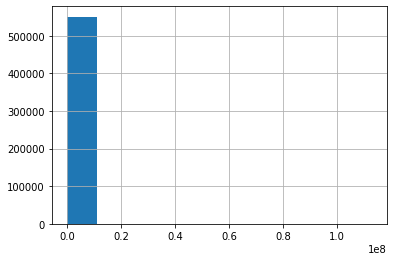

In [13]:
grouped = df.groupby(["engaged_with_user_id"]).agg({"engaged_with_user_follower_count": "mean"})
grouped["engaged_with_user_follower_count"].hist()

The mass of followers are concentrated in the first bin of 1e8 followers. Then we see a long tail ofexception cases with more than 10 million followers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3e8a810>]],
      dtype=object)

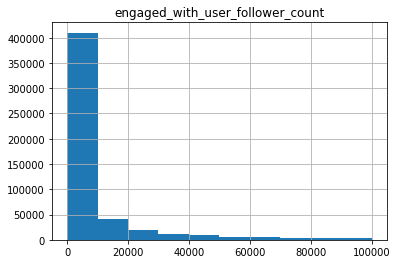

In [14]:
filtered = grouped[grouped["engaged_with_user_follower_count"]<1e5]
filtered.hist()

As we filter the "exceptional" (outliers) cases and further divide into symmetric bins we se an exponential mass function. This happens to "engaged_with_user" and "engaging_user". As we wanted to capture small perturbation of followers/following in small scales and ignore perturbation on large scales , we decided to create logaritmic bins. That bins will be the category acording followers and following of each user.

In [15]:
bins = [ 5**i for i in range(11) ]
bins = [0] + bins
bins

[0, 1, 5, 25, 125, 625, 3125, 15625, 78125, 390625, 1953125, 9765625]

In [16]:
for i in range(5):
    f = bins[i]
    t = bins[i+1]
    values = df["engaged_with_user_follower_count"]
    df["ew_follwer_bin_{}".format(i)] = np.where((f<=values) & (values<t), 1 ,0 )

In [17]:
cols = ["ew_follwer_bin_{}".format(i) for i in range(5)]
df[cols]

,ew_follwer_bin_0,ew_follwer_bin_1,ew_follwer_bin_2,ew_follwer_bin_3,ew_follwer_bin_4
0,0,0,0,0,0
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,0
4,0,0,0,0,1
...,...,...,...,...,...
999995,0,0,0,0,0
999996,0,0,0,0,0
999997,0,0,0,0,0
999998,0,0,0,0,0


### Scores

# Transformer and trining

We coded beformentioned anlyis into TwitterTransform object. This object has a fit method that learns stadistics of a dataframe and use a transform method for extracting features of the dataframe.

In [ ]:
from sklearn.preprocessing import StandardScaler
import re



def set_follow_grouop(df, follow_column, bins_count): 
    bins = [ 5**i for i in range(bins_count) ]
    bins = [0] + bins
    bins
    values = df[follow_column]       
    columns = []
    for i in range(len(bins)-1):
        f = bins[i]
        t = bins[i+1]
        column_name = "{}_bin_{}".format(follow_column, i)
        df[column_name] = np.where((f<=values) & (values<t), 1 ,0 )
        columns.append(column_name)
        
        
class TwitterTransform:
    """takes a df and cleans it to be used as input of a model in matrix form"""
    
    def __init__(self, lang_tol=0):

        self.ss = StandardScaler()
        self.lang_tol = lang_tol
        self.list_languages = []
        self.selection_to_standarize = ["engaged_with_user_follower_count","engaged_with_user_following_count",
                                        "enaging_user_follower_count", "enaging_user_following_count"]
        self.selection_to_boolean = ["engaged_with_user_is_verified", "enaging_user_is_verified", 
                                     "engagee_follows_engager"]
        self.tweet_types =  ['Retweet', 'Quote', 'Reply', 'Toplevel']
        self.labels = ["reply_timestamp","retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]
        self.bins_count = 11
        self.follow_class_columns = [ 
            "engaged_with_user_follower_count",
            "engaged_with_user_following_count",
            "enaging_user_following_count",
            "enaging_user_follower_count",            
        ]
          
    def fit(self, df):
        ##X
        #STANDARIZATION OF FOLLOWERS COUNTS(fit)
        self.ss.fit(df[self.selection_to_standarize])
        
        #Create lisf of languages
        language_series = df.language.value_counts()/len(df)
        self.list_languages = language_series[language_series > self.lang_tol].tolist()
        
        
    def transform(self,df):
        #STANDARIZATION OF FOLLOWERS COUNTS(transform)
        x = df[self.selection_to_standarize]
        x_cols = x.columns
        x = pd.DataFrame(data = self.ss.transform(x), columns = x_cols)
               
        #OneHot encoding of Languages
        for lang in self.list_languages:
            x[lang] = df['language'].apply(lambda x: 1 if (x==lang) else 0)
        
        #OneHot encoding tweet_type
        for types in self.tweet_types:
            x[types] = df['tweet_type'].apply(lambda x: 1 if (x==types) else 0) 
#         x = pd.concat([x, pd.get_dummies(df['tweet_type'])], axis=1)
                
        #OneHot encoding present_media
        x['present_media'] = df['present_media'].apply(lambda x: re.split('\t', x)  if (type(x)==str) else [] )
        for media in ['Photo','Video','GIF']:
            x[media] =  x.present_media.apply(lambda x:  1 if (media  in x) else 0)
        x = x.drop('present_media', axis=1)
                   
        #(True/False)Boolean to (1/0)Boolean
        x = pd.concat( [ x, df[self.selection_to_boolean].astype(int)], axis=1 )
  
        #FOLLOW CLASS
        for follow_column in self.follow_class_columns:
            set_follow_grouop(x, follow_column, self.bins_count)
            x.drop([follow_column],axis=1, inplace=True)
            
        #NUMBER/NaN or BOOLEAN TO INTEGER BOOLEAN(1/0) 
        is_y = all([label in df.columns for label in self.labels])
        
        if is_y:
            y = df[self.labels].notna().astype(int)
            return x.values, y.values
        else:
            return x.values
        
                                          
                                
                                          
                                        

In [18]:
from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0


In [19]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, log_loss
from xgboost import XGBClassifier

def model_scores(x_train, y_train, x_test, y_test, model='default'):
#     list = ['replay','retweet', 'retweet_comment', 'like']

    if model=='default':
        model = XGBClassifier()
    model.fit(x_train,y_train)

    ytrue = y_train
    ypred = model.predict(x_train)
    train = [log_loss(ytrue, ypred), roc_auc_score(ytrue, ypred)]
    train = np.array(train)
 
    ytrue = y_test
    ypred = model.predict(x_test)
    test = [log_loss(ytrue, ypred), roc_auc_score(ytrue, ypred)]
    test = np.array(test)
 
    return train, test
#     print('\n'.join([' '.join([name[:5]]+['{:.4f}'.format(score) for score in engage]) for engage,name in zip(train,engagement_list)]))


def print_scores(matrix, name='METRICS'):
    engagement_list = ['replay      ','retweet      ', 'retweet_comment     ', 'like      ']
    score_list = ['log_loss', 'roc_auc']
    print(name+' log_loss   roc_auc')
    print('\n'.join([' '.join([name[:10]]+['{:.4f}'.format(score) for score in engage]) for engage,name in zip(matrix,engagement_list)]))
    print()
    return

In [ ]:
df_og = pd.read_pickle('train_0.pkl')

In [ ]:
train = {}
for i in range(4):
    train[i] = pd.read_pickle('train_{}.pkl'.format(i))

In [ ]:
engagement = {}
label_list = ['reply','retweet', 'retweet_with_comment', 'like']

for i in range(len(label_list)):
    engagement[label_list[i]] = i
engagement

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

tt = TwitterTransform()
tt.fit(df_og)
x_train, y_train = tt.transform(df_og)

for label in label_list:
    print(label)
    idx = engagement[label]

    xgb = XGBClassifier()
    xgb.fit(x_train, y_train[:,idx])

    gt = {}
    pred = {}
    
    i=2
    x_val,y_val = tt.transform(train[i])
    gt[i] = y_val[:,idx]
    y_pred = xgb.predict(x_val)
#         y_pred = np.zeros(gt[i].shape)
    pred[i] = y_pred
    prauc = compute_prauc(pred[i], gt[i])
    rce = compute_rce(pred[i], gt[i])
    roc = roc_auc_score( gt[i],pred[i])
    print('{}>>> PRAUC:{:.4f} RCE:{:.4f} ROCAUC:{:.4f}'.format(i,prauc, rce, roc))